**Домашнее задание 4:** Напишите хороший пример неэффективного кода для занятия памяти видеокарты, который вызовет ошибку out of memory

**Результаты эксперимента** 

Попробуем создать в локальной переменной тензор, занимающий 25% видеопамяти. В результате работы соответствующей функции в VRAM будет зарезервировано 4.4 GiB видеопамяти. Если мы попробуем при помощи той же функции создать тензор, занимающий 85% видеопамяти, то перевыполнения не произойдёт: PyTorch очистит кеш и зарезервирует в нём необходимые 13 GiB видеопамяти.  
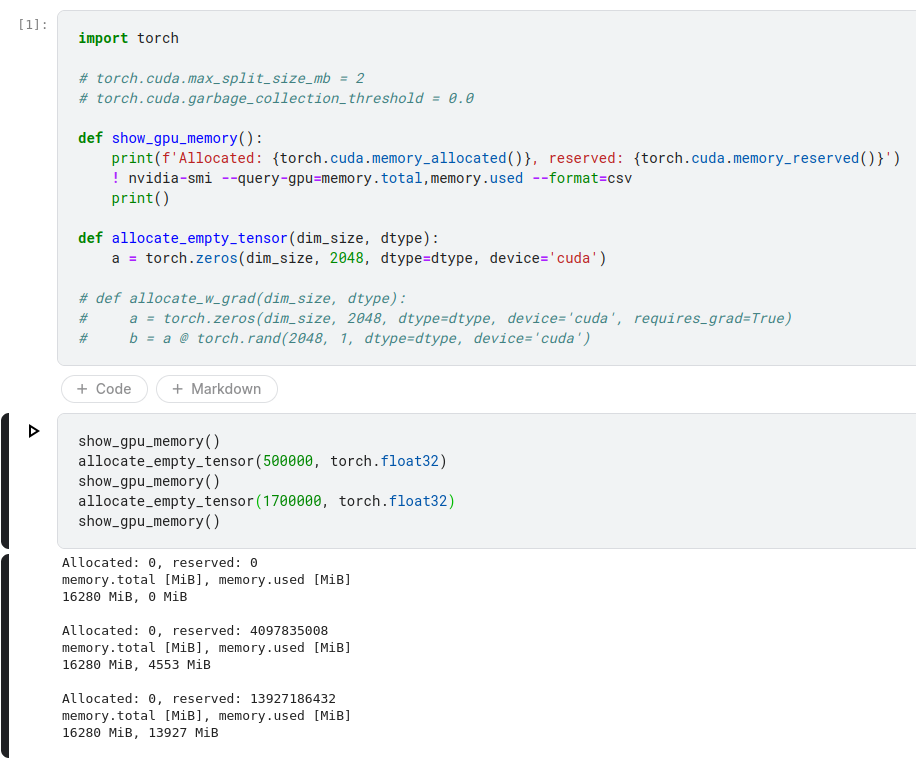

Теперь выполним те же действия, но после создания первого тензора сохраним в переменную другой тензор значительно меньшей размерности. Поскольку этот тензор занимает меньше видеопамяти, его резервация произойдёт внутри уже существующего блока кеша. Затем, как и в предыдущем случае, создадим тензор, занимающий 85% видеопамяти. Видим, что CUDA выдал ошибку "Out of memory". Для создания третьего тензора PyTorch требовалось освободить 25% видеопамяти, занятые блоком кеша. Однако, в отличие от предыдущего случая, этот блок содержит использующуюся переменную, поэтому удалить целиком его нельзя. В результате выводится ошибка о нехватке видеопамяти.  
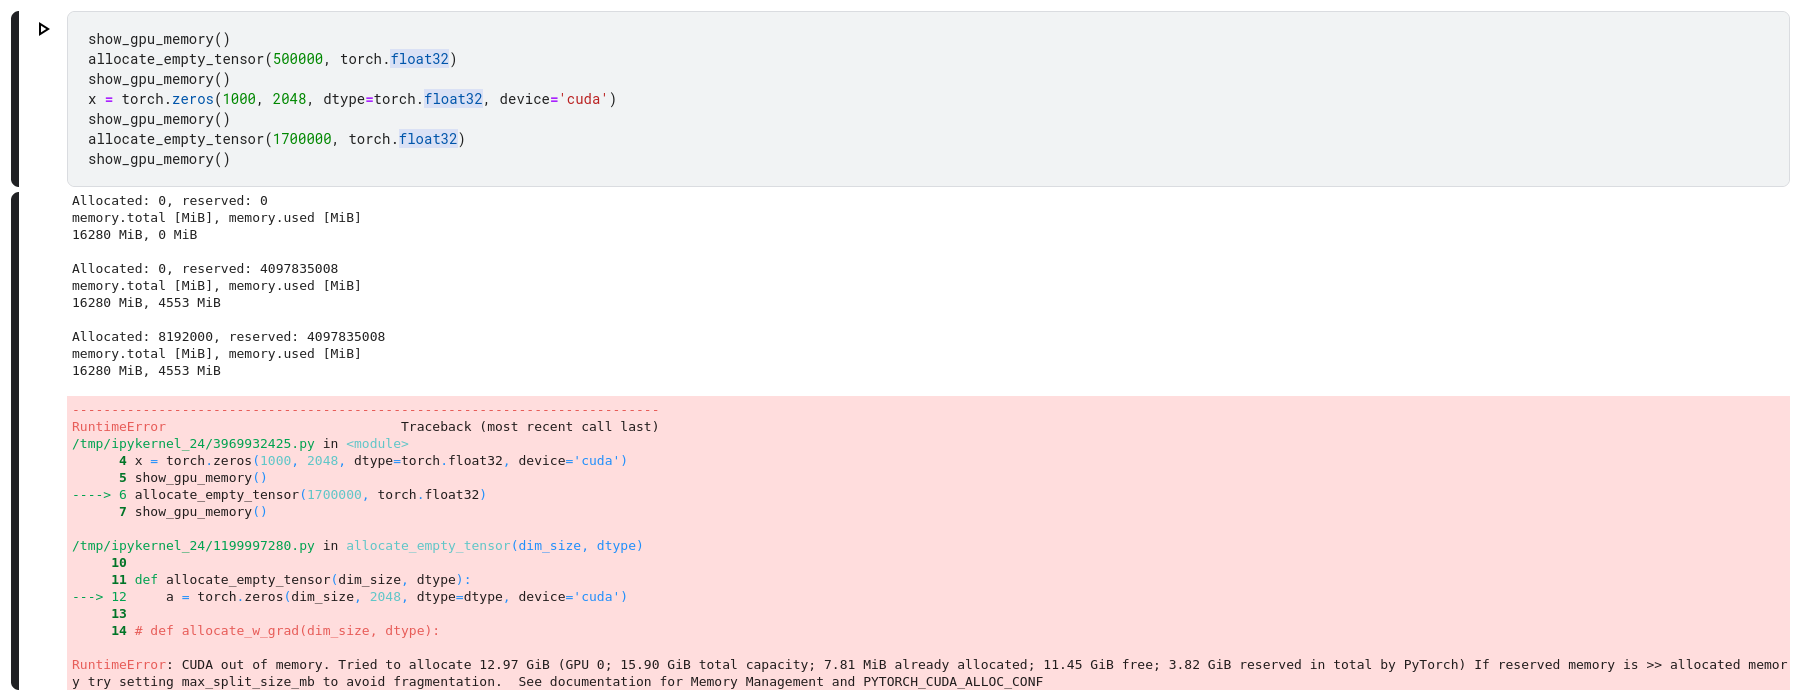

In [ ]:
import torch

# torch.cuda.max_split_size_mb = 2
# torch.cuda.garbage_collection_threshold = 0.0

def show_gpu_memory():
    print(f'Allocated: {torch.cuda.memory_allocated()}, reserved: {torch.cuda.memory_reserved()}')
    ! nvidia-smi --query-gpu=memory.total,memory.used --format=csv
    print()

def allocate_empty_tensor(dim_size, dtype):
    a = torch.zeros(dim_size, 2048, dtype=dtype, device='cuda')
    
# def allocate_w_grad(dim_size, dtype):
#     a = torch.zeros(dim_size, 2048, dtype=dtype, device='cuda', requires_grad=True)
#     b = a @ torch.rand(2048, 1, dtype=dtype, device='cuda')

In [ ]:
show_gpu_memory()
allocate_empty_tensor(500000, torch.float32)
show_gpu_memory()
x = torch.zeros(1000, 2048, dtype=torch.float32, device='cuda')
show_gpu_memory()
allocate_empty_tensor(1700000, torch.float32)
show_gpu_memory()

Allocated: 0, reserved: 0
memory.total [MiB], memory.used [MiB]
16280 MiB, 0 MiB

Allocated: 0, reserved: 4097835008
memory.total [MiB], memory.used [MiB]
16280 MiB, 4553 MiB

Allocated: 8192000, reserved: 4097835008
memory.total [MiB], memory.used [MiB]
16280 MiB, 4553 MiB



RuntimeError: CUDA out of memory. Tried to allocate 12.97 GiB (GPU 0; 15.90 GiB total capacity; 7.81 MiB already allocated; 11.45 GiB free; 3.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.cuda.memory_snapshot()

[{'device': 0,
  'address': 140509217554432,
  'total_size': 4097835008,
  'allocated_size': 8192000,
  'active_size': 8192000,
  'segment_type': 'large',
  'blocks': [{'size': 8192000, 'state': 'active_allocated'},
   {'size': 4089643008, 'state': 'inactive'}]}]

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    8000 KB |    3906 MB |    3914 MB |    3906 MB |
|       from large pool |    8000 KB |    3906 MB |    3914 MB |    3906 MB |
|       from small pool |       0 KB |       0 MB |       0 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    8000 KB |    3906 MB |    3914 MB |    3906 MB |
|       from large pool |    8000 KB |    3906 MB |    3914 MB |

In [ ]:
import torch

def show_gpu_memory():
    print(f'Allocated: {torch.cuda.memory_allocated()}, reserved: {torch.cuda.memory_reserved()}')
    ! nvidia-smi --query-gpu=memory.total,memory.used --format=csv
    print()

def allocate_empty_tensor(dim_size, dtype):
    a = torch.zeros(dim_size, 2048, dtype=dtype, device='cuda')

    
show_gpu_memory()
allocate_empty_tensor(1000000, torch.float32)
show_gpu_memory()
x = torch.zeros(10, 2048, dtype=torch.float32, device='cuda')
show_gpu_memory()

dim = 1100000
while True:
    try:
        allocate_empty_tensor(dim, torch.float32)
        print(f'Allocated: {torch.cuda.memory_allocated()}, reserved: {torch.cuda.memory_reserved()}')
    except RuntimeError as re:
        print(dim)
        print(re)
        break
    dim += 100000
    
show_gpu_memory()

Allocated: 0, reserved: 0
memory.total [MiB], memory.used [MiB]
16280 MiB, 0 MiB

Allocated: 0, reserved: 8193572864
memory.total [MiB], memory.used [MiB]
16280 MiB, 8459 MiB

Allocated: 81920, reserved: 8195670016
memory.total [MiB], memory.used [MiB]
16280 MiB, 8461 MiB

Allocated: 81920, reserved: 9013559296
Allocated: 81920, reserved: 9833545728
Allocated: 81920, reserved: 10653532160
Allocated: 81920, reserved: 11471421440
Allocated: 81920, reserved: 12291407872
Allocated: 81920, reserved: 13109297152
Allocated: 81920, reserved: 13929283584
Allocated: 81920, reserved: 14749270016
Allocated: 81920, reserved: 15567159296
Allocated: 81920, reserved: 16387145728
2100000
CUDA out of memory. Tried to allocate 16.02 GiB (GPU 0; 15.90 GiB total capacity; 80.00 KiB already allocated; 15.27 GiB free; 2.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_

**Домашнее задание 5:** Используя один линейный слой `nn.Linear` и один входной тензор `x` подберите подберите размерности так, чтобы занимать всю видеопамять.
Попробуйте применить линейный слой к тензору `x`. Что произойдет? Кратко опишите ваши эксперименты. Что вы поняли?

**Домашнее задание 4:** Напишите хороший пример неэффективного кода для занятия памяти видеокарты, который вызовет ошибку out of memory

**Результаты эксперимента** 

Попробуем создать в локальной переменной тензор, занимающий 25% видеопамяти. В результате работы соответствующей функции в VRAM будет зарезервировано 4.4 GiB видеопамяти. Если мы попробуем при помощи той же функции создать тензор, занимающий 85% видеопамяти, то перевыполнения не произойдёт: PyTorch очистит кеш и зарезервирует в нём необходимые 13 GiB видеопамяти.  
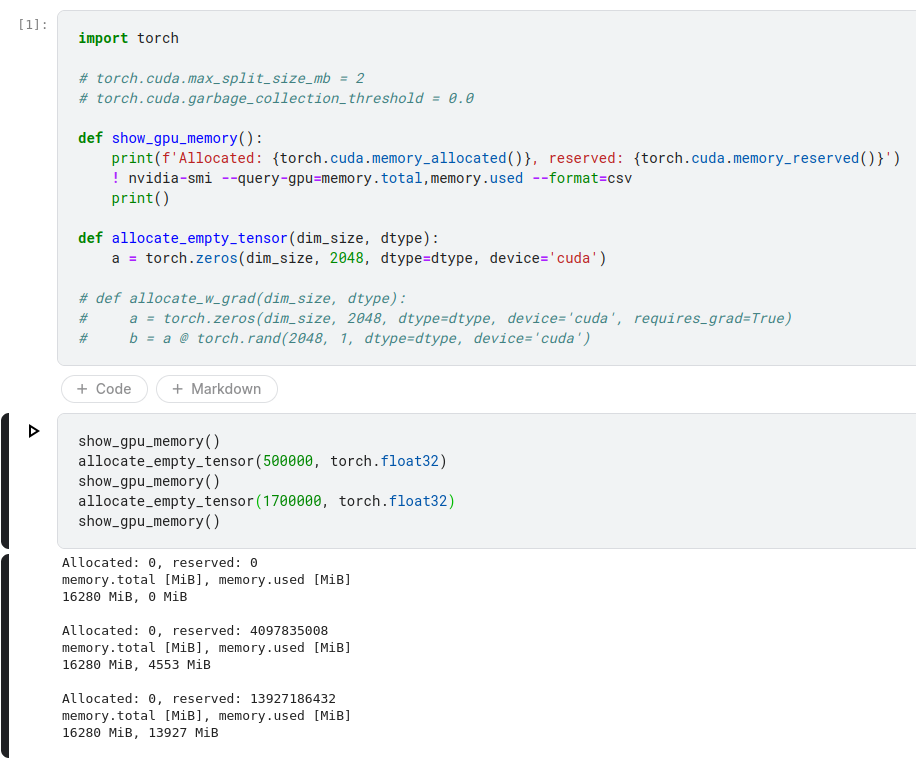

Теперь выполним те же действия, но после создания первого тензора сохраним в переменную другой тензор значительно меньшей размерности. Поскольку этот тензор занимает меньше видеопамяти, его резервация произойдёт внутри уже существующего блока кеша. Затем, как и в предыдущем случае, создадим тензор, занимающий 85% видеопамяти. Видим, что CUDA выдал ошибку "Out of memory". Для создания третьего тензора PyTorch требовалось освободить 25% видеопамяти, занятые блоком кеша. Однако, в отличие от предыдущего случая, этот блок содержит использующуюся переменную, поэтому удалить целиком его нельзя. В результате выводится ошибка о нехватке видеопамяти.  
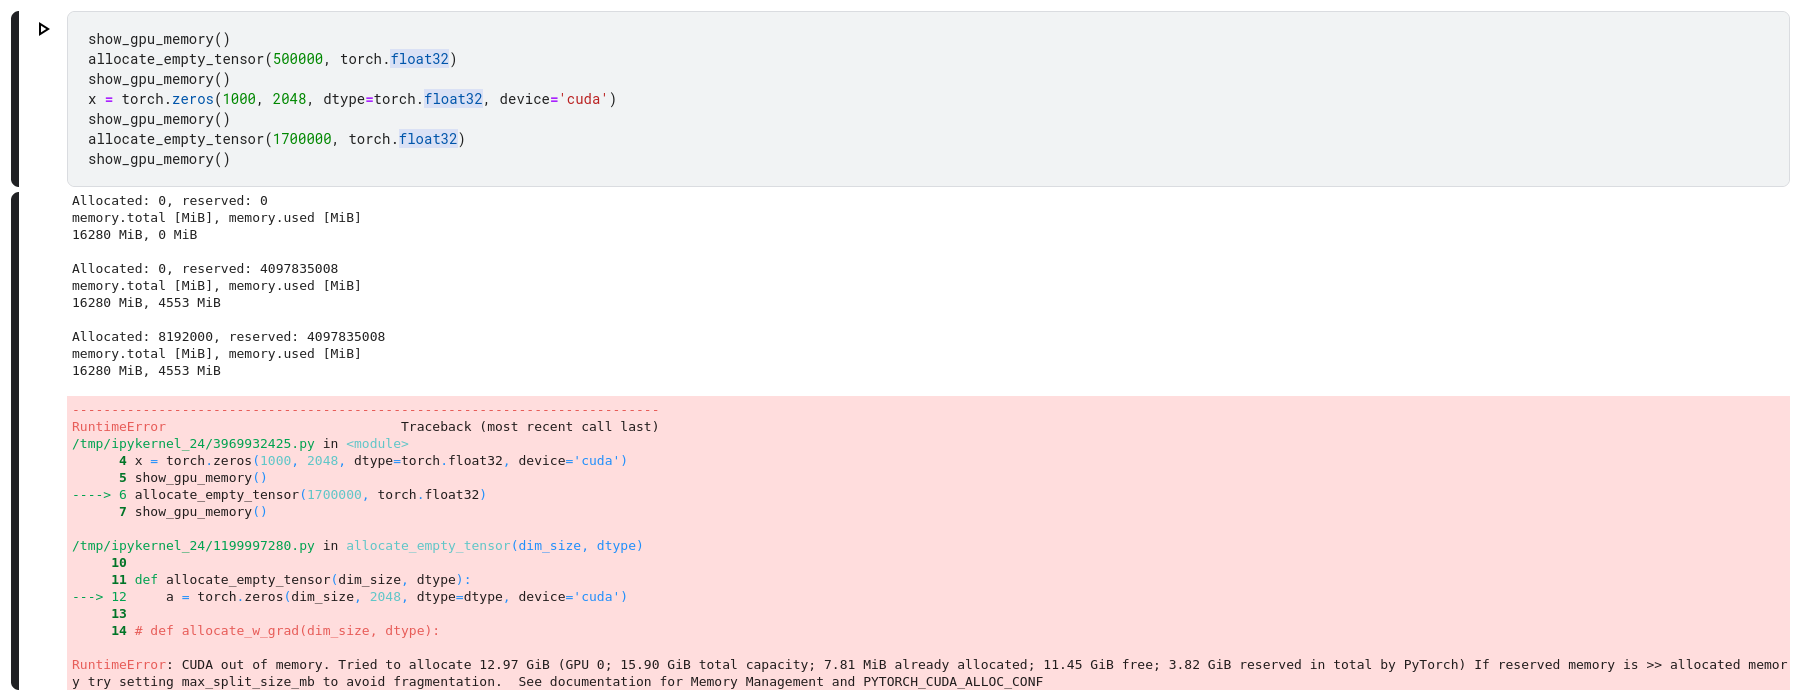

In [ ]:
import torch

# torch.cuda.max_split_size_mb = 2
# torch.cuda.garbage_collection_threshold = 0.0

def show_gpu_memory():
    print(f'Allocated: {torch.cuda.memory_allocated()}, reserved: {torch.cuda.memory_reserved()}')
    ! nvidia-smi --query-gpu=memory.total,memory.used --format=csv
    print()

def allocate_empty_tensor(dim_size, dtype):
    a = torch.zeros(dim_size, 2048, dtype=dtype, device='cuda')
    
# def allocate_w_grad(dim_size, dtype):
#     a = torch.zeros(dim_size, 2048, dtype=dtype, device='cuda', requires_grad=True)
#     b = a @ torch.rand(2048, 1, dtype=dtype, device='cuda')

In [ ]:
show_gpu_memory()
allocate_empty_tensor(500000, torch.float32)
show_gpu_memory()
x = torch.zeros(1000, 2048, dtype=torch.float32, device='cuda')
show_gpu_memory()
allocate_empty_tensor(1700000, torch.float32)
show_gpu_memory()

Allocated: 0, reserved: 0
memory.total [MiB], memory.used [MiB]
16280 MiB, 0 MiB

Allocated: 0, reserved: 4097835008
memory.total [MiB], memory.used [MiB]
16280 MiB, 4553 MiB

Allocated: 8192000, reserved: 4097835008
memory.total [MiB], memory.used [MiB]
16280 MiB, 4553 MiB



RuntimeError: CUDA out of memory. Tried to allocate 12.97 GiB (GPU 0; 15.90 GiB total capacity; 7.81 MiB already allocated; 11.45 GiB free; 3.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.cuda.memory_snapshot()

[{'device': 0,
  'address': 140509217554432,
  'total_size': 4097835008,
  'allocated_size': 8192000,
  'active_size': 8192000,
  'segment_type': 'large',
  'blocks': [{'size': 8192000, 'state': 'active_allocated'},
   {'size': 4089643008, 'state': 'inactive'}]}]

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    8000 KB |    3906 MB |    3914 MB |    3906 MB |
|       from large pool |    8000 KB |    3906 MB |    3914 MB |    3906 MB |
|       from small pool |       0 KB |       0 MB |       0 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    8000 KB |    3906 MB |    3914 MB |    3906 MB |
|       from large pool |    8000 KB |    3906 MB |    3914 MB |

In [ ]:
import torch

def show_gpu_memory():
    print(f'Allocated: {torch.cuda.memory_allocated()}, reserved: {torch.cuda.memory_reserved()}')
    ! nvidia-smi --query-gpu=memory.total,memory.used --format=csv
    print()

def allocate_empty_tensor(dim_size, dtype):
    a = torch.zeros(dim_size, 2048, dtype=dtype, device='cuda')

    
show_gpu_memory()
allocate_empty_tensor(1000000, torch.float32)
show_gpu_memory()
x = torch.zeros(10, 2048, dtype=torch.float32, device='cuda')
show_gpu_memory()

dim = 1100000
while True:
    try:
        allocate_empty_tensor(dim, torch.float32)
        print(f'Allocated: {torch.cuda.memory_allocated()}, reserved: {torch.cuda.memory_reserved()}')
    except RuntimeError as re:
        print(dim)
        print(re)
        break
    dim += 100000
    
show_gpu_memory()

Allocated: 0, reserved: 0
memory.total [MiB], memory.used [MiB]
16280 MiB, 0 MiB

Allocated: 0, reserved: 8193572864
memory.total [MiB], memory.used [MiB]
16280 MiB, 8459 MiB

Allocated: 81920, reserved: 8195670016
memory.total [MiB], memory.used [MiB]
16280 MiB, 8461 MiB

Allocated: 81920, reserved: 9013559296
Allocated: 81920, reserved: 9833545728
Allocated: 81920, reserved: 10653532160
Allocated: 81920, reserved: 11471421440
Allocated: 81920, reserved: 12291407872
Allocated: 81920, reserved: 13109297152
Allocated: 81920, reserved: 13929283584
Allocated: 81920, reserved: 14749270016
Allocated: 81920, reserved: 15567159296
Allocated: 81920, reserved: 16387145728
2100000
CUDA out of memory. Tried to allocate 16.02 GiB (GPU 0; 15.90 GiB total capacity; 80.00 KiB already allocated; 15.27 GiB free; 2.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_